# Evaluation of Machine Learning Methods

## Water permeability prediction in forestry <br>

In this task, the client wants you to estimate the spatial prediction performance of K-nearest neighbor regression model with K=7 (7NN), using spatial leave-one-out cross-validation (i.e. SKCV, with number of folds == number of data points). The client wants you to use the C-index as the performance measure.  

In other words, the client wants you to answer the question: "What happens to the prediction performance of water permeability using 7-nearest neighbor regression model, when the geographical distance between known data and unknown data increases?".

In this task, you have three data files available (with 1691 data points): 

- input.csv, contains the 75 predictor features. 
- output.csv, contains the water permebility values. 
- coordinates.csv, contains the corresponding geographical coordinate locations of the data points. The unit of the coordinates is metre, and you can use Euclidean distance to calculate distances between the coordinate points. 

Implement the following tasks:

********************************************

#### 1. Z-score standardize the predictor features (input.csv). 

#### 2. Perform spatial leave-one-out cross-validation with 7NN model for the provided data set (refer to the lectures 3.1.3 and 3.1.4 in 'Evaluating spatial models with spatial cross-validation' for help). Estimate the water permeability prediction performance (using 7NN model and C-index) with the following distance parameter values: d = 0, 20, 40, ..., 300 (that is, 20 meter intervals from 0m to 300m). 

#### 3. When you have calculated the C-index performance measure for each value of d, visualize the results with the C-index (y-axis) as a function of d (x-axis).

### Import necessary libraries

In [1]:
# In this cell, import all the libraries that you need. For example: 
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsRegressor

### Read in the datasets

In [4]:
# In this cell, read the files input.csv, output.csv and coordinates.csv.
# Print out the dataset dimesions (i.e. number of rows and columns).
input_df = pd.read_csv("input.csv")
print(f"Input Dataset dimensions: {input_df.shape}")
input_df.head

output_df = pd.read_csv("output.csv")
print(f"Output Dataset dimensions: {output_df.shape}")

crd_df = pd.read_csv("coordinates.csv")
print(f"Coordinates Dataset dimensions: {crd_df.shape}")

Input Dataset dimensions: (1690, 75)
Output Dataset dimensions: (1690, 1)
Coordinates Dataset dimensions: (1690, 2)


In [6]:
input_df.head()

,-5.319627000693968877e-02,-2.192960385319173422e-01,2.100203710608411767e-01,7.044248857837395184e-01,3.394767803718533039e-01,4.126382430764711229e-01,3.310743813668211577e-01,-3.441122815090714299e-02,-1.844805104342988333e-01,3.073453044043934490e-01,...,2.195409042303054503e-01,5.391189660033040010e-01,-6.452537679872522025e-01,-5.199176372857478023e-01,-4.470893658464750731e-01,5.540967867205053299e-01,8.728506609344185985e-02,-1.091932125630579592e-01,-9.136390741008875160e-01,-4.614792137924043081e-01
0,-0.632098,-0.682804,-0.285522,-0.369542,-0.138305,2.489725,2.051755,-0.034411,-0.246906,-0.226797,...,0.219541,-0.169259,-0.645254,2.475438,-0.447089,-0.288927,-0.035919,-1.481978,-1.087664,-0.461479
1,-0.674980,-0.597421,-0.568689,-0.983237,-0.828435,-0.496087,-0.451053,-0.034411,-0.324938,-0.627405,...,-1.047724,-0.877636,-0.645254,-0.519918,-0.447089,-0.375320,-0.159124,0.349947,0.134707,-0.809315
2,-0.331927,-0.154649,1.307292,0.090730,0.419107,1.061728,0.956776,-0.034411,-0.301529,-0.360333,...,-1.047724,-0.877636,-0.645254,-0.519918,-0.447089,-0.383278,0.703308,0.467238,0.107450,-0.832933
3,-0.610657,-0.673046,-0.161636,-0.522966,-0.377196,0.672274,0.800351,-0.034411,-0.363954,-0.961244,...,-1.047724,-0.877636,2.098494,0.977760,1.960643,-0.296657,0.087285,-0.333328,-0.636876,-0.542584
4,-0.256884,-0.220516,1.360386,0.857849,0.684542,-0.236451,0.018223,-0.034411,-0.223497,0.107042,...,0.219541,1.247497,3.013076,-0.519918,-0.447089,-0.164565,0.210490,0.735021,-0.729130,-0.587591


### Standardization of the predictor features (input.csv)

In [9]:
# Standardize the predictor features (input.csv) by removing the mean and scaling to unit variance. 
# In other words, z-score the predictor features. You are allowed to use third-party libraries for doing this. 

# initializing the scaler
scaler = StandardScaler()

# applying standardization to all columns
input_df.iloc[:, :] = scaler.fit_transform(input_df)

### Functions and analysis code

In [12]:
# Include here all the functions and other relevant code that you need in order to implement the task.

# Note! Utilize the following two functions in your implementation:

### Function for calculating C-index ###
# y: array containing true label values.
# yp: array containing the predicted label values.
def cindex(y, yp):
    n = 0
    h_num = 0 
    for i in range(0, len(y)):
        t = y[i]
        p = yp[i]
        for j in range(i+1, len(y)):
            nt = y[j]
            np = yp[j]
            if (t != nt): 
                n = n + 1
                if (p < np and t < nt) or (p > np and t > nt): 
                    h_num += 1
                elif (p == np):
                    h_num += 0.5
    return h_num/n


### Function for calculating the pairwise spatial distances between the data points ###
# The function will return a n-by-n matrix of Euclidean distances. For example, the
# distance_matrix element at indices i,j will contain the spatial distance between 
# data point i and j. Note that the element value is 0 always when i==j.
# coordinate_array: n-by-2 array containing the coordinates of the exercise data points.
def cdists(coordinate_array):
    number_of_observations = coordinate_array.shape[0]
    distance_matrix = np.zeros((number_of_observations, number_of_observations))
    for i in range(0, number_of_observations):
        distance_matrix[i, :] = np.sqrt(np.sum((coordinate_array - coordinate_array[i])**2, axis=1))
    return distance_matrix

# Function to perform Spatial Leave-One-Out Cross-Validation with 7NN
def sloo_with_distance_threshold(input_df, output_df, crd_df, distance_thresholds, n_neighbors=7):
    # First extracting predictor features, target variable, and coordinates
    X = input_df.values 
    y = output_df.values.flatten()
    coordinates = crd_df.values 

    # calculating spatial distance matrix
    distance_matrix = cdists(coordinates)

    cindex_results = {}

    for d in distance_thresholds:
        # lists to store true and predicted values
        true_values = []
        predicted_values = []

        # implementation of LOOCV starts from here
        for i in range(len(y)):
            train_indices = np.arange(len(y)) != i
            test_index = i

            # find the 7 nearest neighbors within the distance threshold
            neighbors_within_threshold = np.where(distance_matrix[test_index, train_indices] <= d)[0]
            if len(neighbors_within_threshold) > n_neighbors:
                neighbors_within_threshold = neighbors_within_threshold[:n_neighbors]

            # if no neighbors are within the threshold distance, use the mean of the target variable as the prediction
            if len(neighbors_within_threshold) == 0:
                y_pred = np.mean(y[train_indices])
            else:
                # ensure at least 1 neighbor for KNeighborsRegressor
                n_neighbors_to_use = max(1, len(neighbors_within_threshold))
                knn = KNeighborsRegressor(n_neighbors=n_neighbors_to_use)

                # training the 7NN regressor on the selected neighbors
                knn.fit(coordinates[train_indices][neighbors_within_threshold], y[train_indices][neighbors_within_threshold])

                # predicting for the left-out point
                y_pred = knn.predict([coordinates[test_index]])[0]

            # storing the results
            true_values.append(y[test_index])
            predicted_values.append(y_pred)

        # applied conversion of lists to arrays
        true_values = np.array(true_values)
        predicted_values = np.array(predicted_values)

        # call to c-index function to calculate it
        c_index_value = cindex(true_values, predicted_values)

        # storing results
        cindex_results[d] = {'c-index': c_index_value}

        print(f"Distance threshold: {d} meters - c-index: {c_index_value:.4f}")

    # after the index calculation, ploting c-index results for different distance thresholds
    thresholds = list(cindex_results.keys())
    cindex_values = [cindex_results[d]['c-index'] for d in thresholds]

    plt.figure(figsize=(8, 6))
    plt.plot(thresholds, cindex_values, marker='o', linestyle='-', color='b', label="c-index")
    plt.xlabel("Distance Threshold (meters)")
    plt.ylabel("c-index")
    plt.title("c-index vs. Distance Thresholds for SLOO-CV ")
    plt.grid(True)
    plt.legend()
    plt.show()

    return cindex_results

### Results for spatial leave-one-out cross-validation with 7-nearest neighbor regression model

Distance threshold: 0 meters - c-index: 0.6356
Distance threshold: 20 meters - c-index: 0.6761
Distance threshold: 40 meters - c-index: 0.6732
Distance threshold: 60 meters - c-index: 0.6794
Distance threshold: 80 meters - c-index: 0.6775
Distance threshold: 100 meters - c-index: 0.6781
Distance threshold: 120 meters - c-index: 0.6728
Distance threshold: 140 meters - c-index: 0.6708
Distance threshold: 160 meters - c-index: 0.6706
Distance threshold: 180 meters - c-index: 0.6712
Distance threshold: 200 meters - c-index: 0.6806
Distance threshold: 220 meters - c-index: 0.6863
Distance threshold: 240 meters - c-index: 0.6910
Distance threshold: 260 meters - c-index: 0.6920
Distance threshold: 280 meters - c-index: 0.6917
Distance threshold: 300 meters - c-index: 0.6913


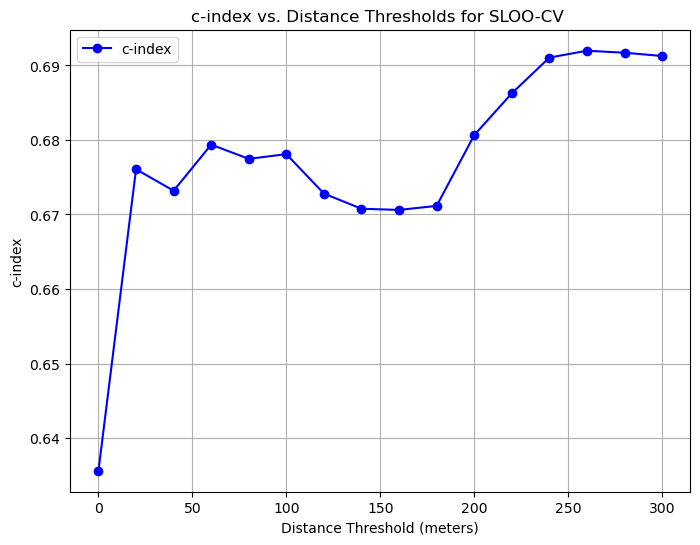

In [15]:
# In this cell, run your script for the Spatial leave-One-Out cross-validation 
# with 7-nearest neighbor regression model and visualize the results as 
# requested in the task assignment.

# defining the distance thresholds to pass it to 
distance_thresholds = np.arange(0, 301, 20)

# call to function that performs sloo-cv
results = sloo_with_distance_threshold(input_df, output_df, crd_df, distance_thresholds)

## Analysis of the results

### In this cell, you need to answer the client's questions:


1. What happens to the 7NN performance as the prediction distance increases?


2. Do you think the results behave as was somewhat expected? Do they make sense, why?


3. If we require that the 7NN must have at least C-index performance of 0.68, then up to what distance should we trust the 7NN predictions, based on the results?

<font color = green> 1. As the prediction distance increases, the performance of the model improves initially and the c-index rises until it peaks at a distance threshold of 260 meters. This shows that including more neighbors improves the model’s predictions by capturing more relevant data points. However, beyond this threshold, the performance stabilizes, with only minor fluctuations in the c-index, suggesting that further increasing the distance does not really improves predictive accuracy. This takes us to the final conclusion which is that The model works best with a balanced distance threshold, where there are enough relevant neighbors for accurate predictions. <br>
2. Yes I think the results do behave in an expected way. As you can see in the plot above, at start, as the prediction distance increases, the performance of the model improves. This actually makes sense because using more relevant neighbors usually leads to better predictions. Moreover, the c-index rises as the distance increases. This shows that including more neighbors helps the model by capturing more contextual information. However, after a certain threshold which is around 260 meters in this case, the performance stabilizes. This is actually expected because at larger distances, the neighbors may become less relevant, and the model reaches a point where additional neighbors do not contribute, suggesting that the optimal number of relevant neighbors has been reached. <br>
3. Based on the results, if we require the model to have at least a c-index performance of 0.68, we can trust the predictions up to a distance of approximately 220 meters. Beyond this distance, the c-index exceeds 0.68, but the performance stabilizes around 0.69 at 240 meters. I shows that the model's predictive power levels off after this point. Therefore, for a consistent performance above the 0.68 threshold, distances up to 220 meters are reliable for the predictions.